# Training Pattern Analysis
## Investigating consistent pacing vs. faster races (2019-2025)

Generated by Claude Sonnet 4.5 on 2025-11-21

In [7]:
import sqlite3
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path
from datetime import datetime, timedelta

db_path = Path.cwd().parent / "msiysp_dev.db"
conn = sqlite3.connect(db_path)

# Load all running activities
activities = pd.read_sql(
    "SELECT * FROM activities WHERE type = 'Run' ORDER BY date", 
    conn,
    parse_dates=['date']
)

# Calculate derived fields
activities['year'] = activities['date'].dt.year
activities['distance_miles'] = activities['distance_meters'] / 1609.34
activities['duration_minutes'] = activities['duration_seconds'] / 60
activities['pace_per_mile'] = activities['duration_seconds'] / activities['distance_miles']
activities['pace_minutes'] = activities['pace_per_mile'] / 60
activities['is_race'] = activities['strava_workout_type'] == 1

print(f"Total activities: {len(activities)}")
print(f"Date range: {activities['date'].min()} to {activities['date'].max()}")
print(f"Total races: {activities['is_race'].sum()}")

Total activities: 1995
Date range: 2019-08-31 20:57:37+00:00 to 2025-11-19 20:33:32+00:00
Total races: 23


## Hypothesis 2: Long Run Progression
Did longer training runs increase over time?

Longest run per year (miles):
year
2019    26.62
2020    20.00
2021    26.44
2022    34.18
2023    26.41
2024    26.34
2025    26.09
Name: distance_miles, dtype: float64

Average of 10 longest runs per year (miles):
year
2019    11.73
2020    14.78
2021    17.16
2022    19.36
2023    16.44
2024    14.94
2025    12.50
dtype: float64



/var/folders/4x/b8lx8clx3jggkzz34lg1cky00000gn/T/ipykernel_27800/3118198921.py:11: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



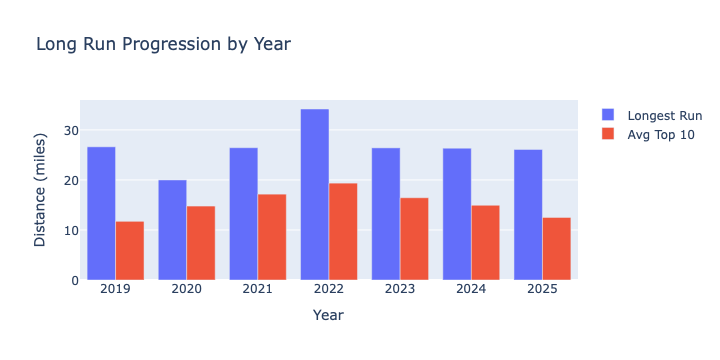

In [8]:
# Longest run per year
longest_runs = activities.groupby('year')['distance_miles'].max().round(2)
print("Longest run per year (miles):")
print(longest_runs)
print()

# Average of top 10 longest runs per year
def avg_top_n_runs(group, n=10):
    return group.nlargest(n, 'distance_miles')['distance_miles'].mean()

avg_long_runs = activities.groupby('year').apply(avg_top_n_runs).round(2)
print("Average of 10 longest runs per year (miles):")
print(avg_long_runs)
print()

# Visualize
fig = go.Figure()
fig.add_trace(go.Bar(x=longest_runs.index, y=longest_runs.values, name='Longest Run'))
fig.add_trace(go.Bar(x=avg_long_runs.index, y=avg_long_runs.values, name='Avg Top 10'))
fig.update_layout(
    title='Long Run Progression by Year',
    xaxis_title='Year',
    yaxis_title='Distance (miles)',
    barmode='group'
)
fig.show()

## Hypothesis 3: Workout Mix (Pace Distribution)
Are you running more easy miles (which lowers average pace but improves fitness)?

Pace distribution by year (min/mile, races excluded):
      count  mean   25%   50%   75%
year                               
2019   28.0  7.64  7.08  7.42  8.09
2020  309.0  7.63  7.27  7.52  7.79
2021  327.0  7.78  7.24  7.57  8.01
2022  335.0  8.12  7.53  7.91  8.38
2023  347.0  7.74  7.43  7.64  7.91
2024  331.0  7.86  7.62  7.80  7.98
2025  295.0  7.84  7.61  7.81  8.03

Pace category mix by year (%):
pace_category  Easy (>9:30)  Fast (<8:00)  Moderate (8:00-9:30)
year                                                           
2019                    3.6          75.0                  21.4
2020                    1.3          83.8                  14.9
2021                    5.2          74.0                  20.8
2022                    8.1          57.3                  34.6
2023                    1.2          82.7                  16.1
2024                    1.8          76.1                  22.1
2025                    1.4          72.5                  26.1



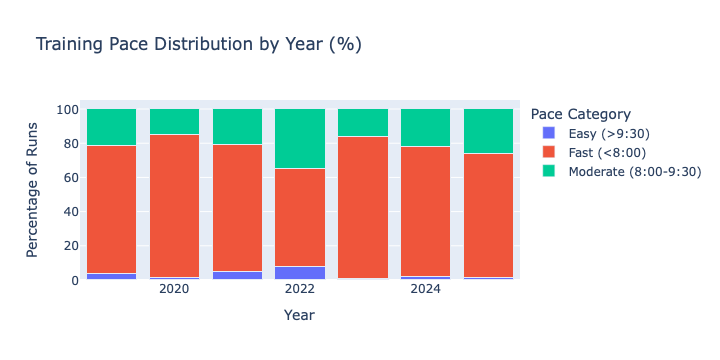

In [4]:
# Overall pace distribution by year
pace_stats = activities[~activities['is_race']].groupby('year')['pace_minutes'].describe()
print("Pace distribution by year (min/mile, races excluded):")
print(pace_stats[['count', 'mean', '25%', '50%', '75%']].round(2))
print()

# Categorize runs by pace (adjust thresholds based on your typical paces)
# These are example thresholds - adjust based on output above
def categorize_pace(pace_minutes):
    if pace_minutes < 8.0:
        return 'Fast (<8:00)'
    elif pace_minutes < 9.5:
        return 'Moderate (8:00-9:30)'
    else:
        return 'Easy (>9:30)'

activities['pace_category'] = activities['pace_minutes'].apply(categorize_pace)

# Count by category and year (exclude races)
pace_mix = activities[~activities['is_race']].groupby(['year', 'pace_category']).size().unstack(fill_value=0)
pace_mix_pct = pace_mix.div(pace_mix.sum(axis=1), axis=0) * 100

print("Pace category mix by year (%):")
print(pace_mix_pct.round(1))
print()

# Visualize
fig = px.bar(
    pace_mix_pct.reset_index().melt(id_vars='year', var_name='Pace Category', value_name='Percentage'),
    x='year',
    y='Percentage',
    color='Pace Category',
    title='Training Pace Distribution by Year (%)',
    labels={'year': 'Year', 'Percentage': 'Percentage of Runs'},
    barmode='stack'
)
fig.show()

## Hypothesis 4: Periodization (Taper Before Races)
Are you resting more before races in recent years?

In [5]:
# Get all races
races = activities[activities['is_race']].copy().sort_values('date')

# For each race, calculate days since last run and volume in 7 days before
taper_analysis = []

for idx, race in races.iterrows():
    race_date = race['date']
    
    # Last run before race
    prior_runs = activities[(activities['date'] < race_date)].sort_values('date', ascending=False)
    if len(prior_runs) > 0:
        days_since_last = (race_date - prior_runs.iloc[0]['date']).days
    else:
        days_since_last = None
    
    # Miles in 7 days before race (excluding race day)
    week_before = activities[
        (activities['date'] >= race_date - timedelta(days=7)) & 
        (activities['date'] < race_date)
    ]
    miles_week_before = week_before['distance_miles'].sum()
    
    taper_analysis.append({
        'race_date': race_date,
        'year': race['year'],
        'race_name': race['name'],
        'race_distance': race['distance_miles'],
        'race_pace': race['pace_minutes'],
        'days_since_last_run': days_since_last,
        'miles_week_before': miles_week_before
    })

taper_df = pd.DataFrame(taper_analysis)

# Summary by year
taper_summary = taper_df.groupby('year').agg({
    'days_since_last_run': 'mean',
    'miles_week_before': 'mean',
    'race_pace': 'mean'
}).round(2)

print("Average taper pattern by year:")
print(taper_summary)
print()

# Show individual races
print("Individual race taper data:")
print(taper_df[['race_date', 'race_name', 'race_distance', 'race_pace', 'days_since_last_run', 'miles_week_before']].to_string(index=False))

Average taper pattern by year:
      days_since_last_run  miles_week_before  race_pace
year                                                   
2023                 0.18              48.30       6.79
2024                 0.25              37.56       6.35
2025                 0.75              29.85       6.48

Individual race taper data:
                race_date                     race_name  race_distance  race_pace  days_since_last_run  miles_week_before
2023-07-19 23:10:02+00:00               Harrisburg Mile       0.998111   5.310031                    0          31.878907
2023-09-10 12:00:11+00:00               Harrisburg Half      13.119353   6.447218                    0          50.177526
2023-10-13 18:16:01+00:00  2023 PA Ragnar Run 1 (Leg 6)       8.589670   7.223793                    1          33.944226
2023-10-13 22:44:54+00:00 2023 PA Ragnar Run 2 (Leg 12)       9.073285   7.621275                    0          42.533896
2023-10-14 03:07:12+00:00 2023 PA Ragnar Run 3 (Le

## Hypothesis 5: Race Frequency
Are you racing less frequently (more selective)?

Races per year:
year
2023    11
2024     8
2025     4
dtype: int64

Races as % of total runs:
year
2019    NaN
2020    NaN
2021    NaN
2022    NaN
2023    3.1
2024    2.4
2025    1.3
dtype: float64



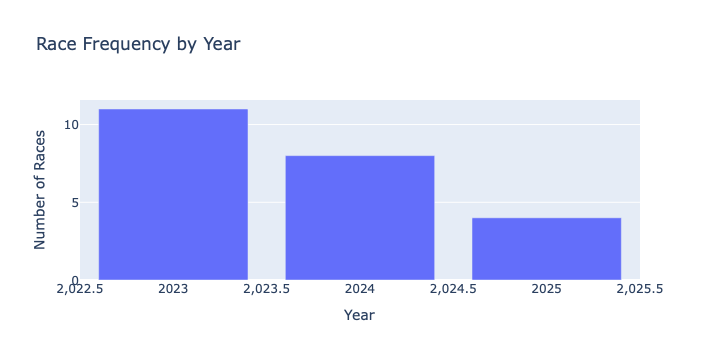

In [6]:
# Count races per year
races_per_year = activities[activities['is_race']].groupby('year').size()
print("Races per year:")
print(races_per_year)
print()

# Total runs per year for context
runs_per_year = activities.groupby('year').size()
race_percentage = (races_per_year / runs_per_year * 100).round(1)
print("Races as % of total runs:")
print(race_percentage)
print()

# Visualize
fig = go.Figure()
fig.add_trace(go.Bar(x=races_per_year.index, y=races_per_year.values, name='Races'))
fig.update_layout(
    title='Race Frequency by Year',
    xaxis_title='Year',
    yaxis_title='Number of Races'
)
fig.show()

## Race Performance Trend
Confirm that race paces are indeed improving

In [ ]:
# Average race pace by year
race_pace_trend = activities[activities['is_race']].groupby('year')['pace_minutes'].mean().round(2)
print("Average race pace by year (min/mile):")
print(race_pace_trend)
print()

# Compare to training pace
training_pace = activities[~activities['is_race']].groupby('year')['pace_minutes'].mean().round(2)
pace_comparison = pd.DataFrame({
    'Training Pace': training_pace,
    'Race Pace': race_pace_trend,
    'Gap': (training_pace - race_pace_trend).round(2)
})

print("Training vs Race Pace (min/mile):")
print(pace_comparison)
print()

# Visualize
fig = go.Figure()
fig.add_trace(go.Scatter(x=training_pace.index, y=training_pace.values, mode='lines+markers', name='Training Pace'))
fig.add_trace(go.Scatter(x=race_pace_trend.index, y=race_pace_trend.values, mode='lines+markers', name='Race Pace'))
fig.update_layout(
    title='Training vs Race Pace by Year',
    xaxis_title='Year',
    yaxis_title='Pace (min/mile)',
    yaxis_autorange='reversed'  # Faster pace = lower number = higher on chart
)
fig.show()

## Summary: What's Driving Your Improvement?

Review the outputs above to identify:
1. **Long runs**: Are your longest runs getting longer?
2. **Pace distribution**: Are you running more easy miles (higher % in "Easy" category)?
3. **Taper**: Are you resting more before races in recent years?
4. **Race frequency**: Are you racing less often (more selective/better prepared)?
5. **Training vs race gap**: Is the gap between training and race pace widening?

Combined with your volume increase (1700→2200 mi/year), these patterns explain how consistent training pace can coexist with faster race times.